In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
# Task 1. Display some images that were downloaded. (Problem 1)

folders = np.random.choice(train_folders, 5)
for folder in folders:
    fname = np.random.choice(os.listdir(folder))
    file = os.path.join(folder, fname)
    label = folder[-1]
    print(label)
    display(Image(filename=file))

B


I


I


B


G


In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

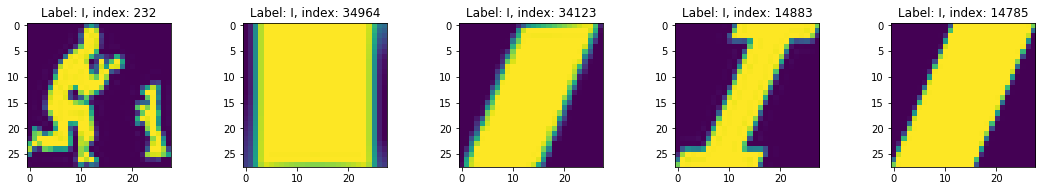

In [8]:
# Task 2. Display images from datasets. (Problem 2)

sample_dataset_file = np.random.choice(train_datasets)
try:
    with open(sample_dataset_file, 'rb') as f:
        sample_dataset = pickle.load(f)
except Exception as e:
    print('Error loading file:', e)

number_of_samples = 5
indices = np.random.choice(sample_dataset.shape[0], number_of_samples)
# combined_img_dataset = np.ndarray(shape=(number_of_samples*image_size, image_size), dtype=np.float32)

i = 0
w = 0.5
label = sample_dataset_file[-8:-7]
fig = plt.figure()
for index in indices:
    # combined_img_dataset[i*image_size:(i+1)*image_size, :] = sample_dataset[index, :, :]
    i += 1
    
    pos = [i*w, 1, w, w]
    a = fig.add_axes(pos)

    a.imshow(sample_dataset[index, :, :])
    a.set_title("Label: %s, index: %s" % (label, index))


In [9]:
# Task 3. Check that data is balanced across classes. (Problem 3)

for train_dataset_file in train_datasets:
    test_dataset_file = train_dataset_file.replace('large', 'small')
    label = train_dataset_file[15:17]
    try:
        with open(train_dataset_file, 'rb') as f:
            train_dataset = pickle.load(f)
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    except Exception as e:
        print('Error loading file:', e)
    print(label, train_dataset.shape[0], '=>', test_dataset.shape[0])

A. 52909 => 1872
B. 52911 => 1873
C. 52912 => 1873
D. 52911 => 1873
E. 52912 => 1873
F. 52912 => 1872
G. 52912 => 1872
H. 52912 => 1872
I. 52912 => 1872
J. 52911 => 1872


In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

200000 [183297  26161 171020  65335  78267]


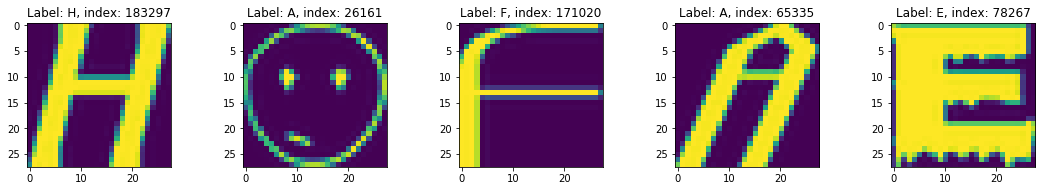

In [14]:
# Task 4. Convincing that the data still smells good. (Problem 4)

sample_dataset = train_dataset
number_of_samples = 5

indices = np.random.choice(sample_dataset.shape[0], number_of_samples)

print(sample_dataset.shape[0], indices)

i = 0
w = 0.5

fig = plt.figure()
for index in indices:
    label = train_datasets[train_labels[index]][15:16]

    i += 1
    
    pos = [i*w, 1, w, w]
    a = fig.add_axes(pos)

    show_arr = sample_dataset[index, :, :]
    #show_arr = show_arr*255 + 255/2
    #show_arr = rgb2grey(show_arr)
    a.imshow(show_arr)
    
    a.set_title("Label: %s, index: %s" % (label, index))


In [11]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



Intersecting
test_dataset(10000)  vs  train_dataset(200000)
Size of unique overlap: 1
test_dataset:1 => 1

Intersecting
test_dataset(10000)  vs  valid_dataset(10000)
Size of unique overlap: 1
test_dataset:57 => 1

Intersecting
train_dataset(200000)  vs  valid_dataset(10000)
Size of unique overlap: 2
train_dataset:36 => 102
train_dataset:3495 => 2


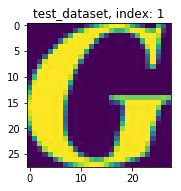

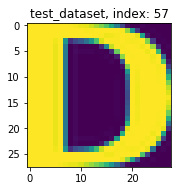

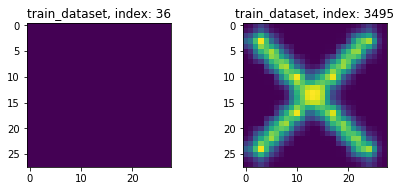

In [18]:
# Task 5. Measure how much overlap there is between training, validation and test samples. (Problem 5)

try:
    f = open(pickle_file, 'rb')
    dataset_from_file = pickle.load(f)
except Exception as e:
    print('Error loading file:', e)

names = ['train_dataset', 'valid_dataset', 'test_dataset']
arr = {
    names[0]:dataset_from_file[names[0]],
    names[1]:dataset_from_file[names[1]],
    names[2]:dataset_from_file[names[2]]
}
sizes = {
    names[0]: train_size,
    names[1]: valid_size,
    names[2]: test_size
}

def intersect(set1, set2):

    matches = {}
    ua = []

    intrsn = np.empty(shape=(0, 28, 28))

    ia = np.empty(shape=(28, 28))
    ja = np.empty(shape=(28, 28))

    # now let's measure overlap between the following datasets
    current = [set1, set2]
    for i in range(sizes[set1]):
        ia = arr[current[0]][i, :, :]

        # check for uniqeness
        if np.count_nonzero(ua == ia) == 0:

            for j in range(sizes[set2]):
                ja = arr[current[1]][j, :, :]
                if np.array_equal(ia, ja):
                    # add overlapping arrays to matches
                    key = current[0] + ':' + str(i)
                    value = { 'name': current[1], 'index': j }
                    if key in matches:
                        matches[key].append(value)
                    else:
                        matches[key] = [ value ]

                    # add the instance to array of unique occurances
                    if np.count_nonzero(ua == ia) == 0:
                        ua.append( ia )
    return matches
    
def visualize(set1, set2, matches):
    i = 0
    w = 0.5

    fig = plt.figure()
    for k, v in matches.items():
        print(k, '=>', len(v))

        if i == 5: break
        i += 1

        pos = [i*w, 1, w, w]
        a = fig.add_axes(pos)

        name, index = k.split(':')

        show_arr = arr[name][int(index), :, :]
        a.imshow(show_arr)
        a.set_title("%s, index: %s" % (name, index))

        
for pair in [[2,0], [2,1], [0,1]]:
    sets = [names[pair[0]], names[pair[1]]]
    matches = intersect(sets[0], sets[1])

    print('')
    print('Intersecting')
    print('%s(%s)  vs  %s(%s)' % (sets[0], sizes[sets[0]], sets[1], sizes[sets[1]]))
    print("Size of unique overlap: %s" % (len(matches)))
    
    visualize(sets[0],sets[1],matches)
    
    

Let's sanitaize datasets to have them as well just for comparison in subsequent assignments.

First, let's filter out all duplicates in each set.
Unfortnately I don't have enough time to process all the data given, so I'll limit datasets to first 1000 items. Also I will not store them on disk.

Next, we need to remove overlapping between data sets. I've been playing around and found out that most of overlapping occur due to duplicated items within sets. Since I skipped filtering out duplicates - there's not much sense removing overlaps. So I skipp it as well.

Below is the snippet to find duplicates in first 1000 items and create sanitized datasets for each of three sets.

In [48]:
def find_duplicates(data_set):
    dup_indices = [];
    size = len(data_set);
    for i, pancake1 in enumerate(data_set):
        for j, pancake2 in enumerate(data_set[(i + 1):]):
            if np.array_equal(pancake1, pancake2):
                dup_indices.append(i + j + 1);
    return list(set(dup_indices));

# only first 1000 items
temp = train_dataset[:1000];
dup_indices = find_duplicates(temp);
print(dup_indices);
san_train_dataset = np.delete(temp, dup_indices, 0);

# only first 1000 items
temp = valid_dataset[:1000];
dup_indices = find_duplicates(temp);
print(dup_indices);
san_valid_dataset = np.delete(temp, dup_indices, 0);

# only first 1000 items
temp = test_dataset[:1000];
dup_indices = find_duplicates(temp);
print(dup_indices);
san_test_dataset = np.delete(temp, dup_indices, 0);


[577, 355, 838, 689, 786]
[963, 964, 933, 711, 590, 911, 593, 562, 148, 597, 342, 667]
[198, 777, 620, 268, 845, 246, 954, 223]


In [108]:
# Task 6. Finally we need to train a model.

regr = LogisticRegression()

X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

def X_train(size):
    return train_dataset[:size].reshape(size, 784)

def y_train(size):
    return train_labels[:size]

def visualize_weights(data):
    total_count = len(data)

    fig = plt.figure(figsize=(18, 8))
    fig.suptitle('Weights visualization', size=16)

    for i, layer in enumerate(data):
        a = fig.add_subplot(2,5,i + 1)

        arr = np.array(layer).reshape(28, 28)
        a.imshow(arr)

        a.set_title("Label: -, index: %s" % (i))

In order to get a better sense on what is going on with our weights let us visulize them oer each training size (12, 50, 1000 and 5000).

We will use `visualize_weights` method for all 10 classes.
>Please notice, that the shape of matrix containing all trained weights is `n x 784`, where `n` is the number of logit classes trained. Hence, in some cases with small training datasets - `n` might be less then 10.

Score: 0.2998


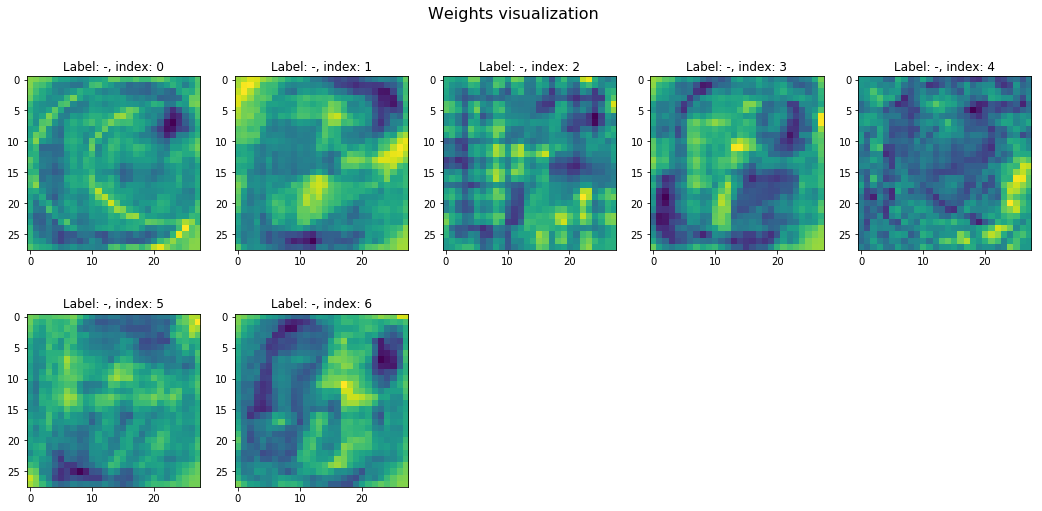

In [113]:
sample_size = 12

regr.fit(X_train(sample_size), y_train(sample_size))
score = regr.score(X_test, y_test)

print("Score: %s" % (score))
visualize_weights(regr.coef_)

Score: 0.509


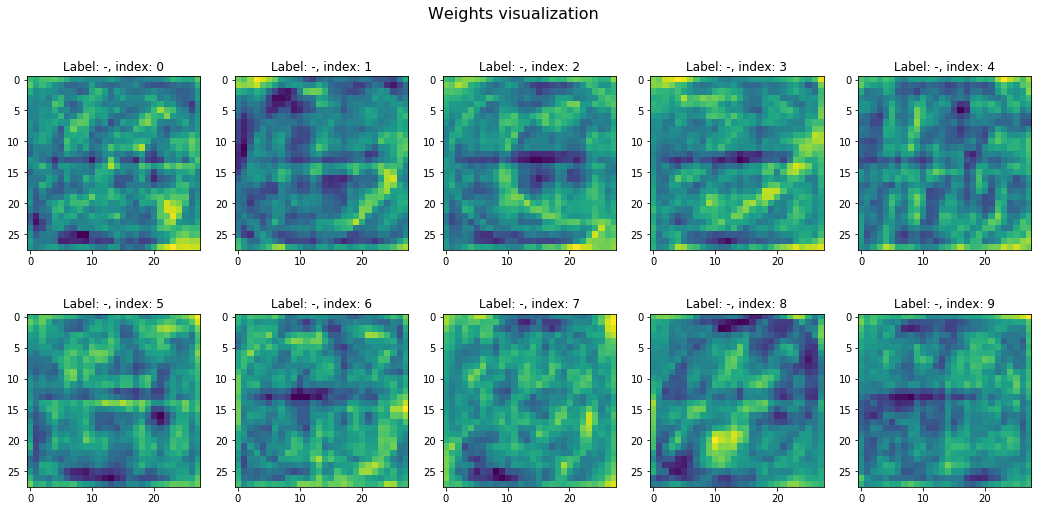

In [110]:
sample_size = 50

regr.fit(X_train(sample_size), y_train(sample_size))
score = regr.score(X_test, y_test)

print("Score: %s" % (score))
visualize_weights(regr.coef_)

Score: 0.8333


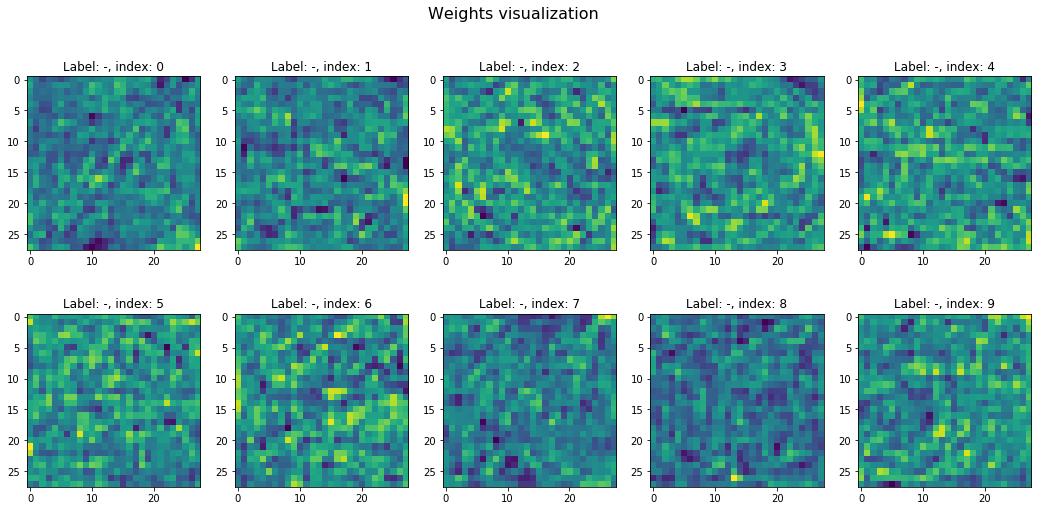

In [111]:
sample_size = 1000

regr.fit(X_train(sample_size), y_train(sample_size))
score = regr.score(X_test, y_test)

print("Score: %s" % (score))
visualize_weights(regr.coef_)

Score: 0.8511


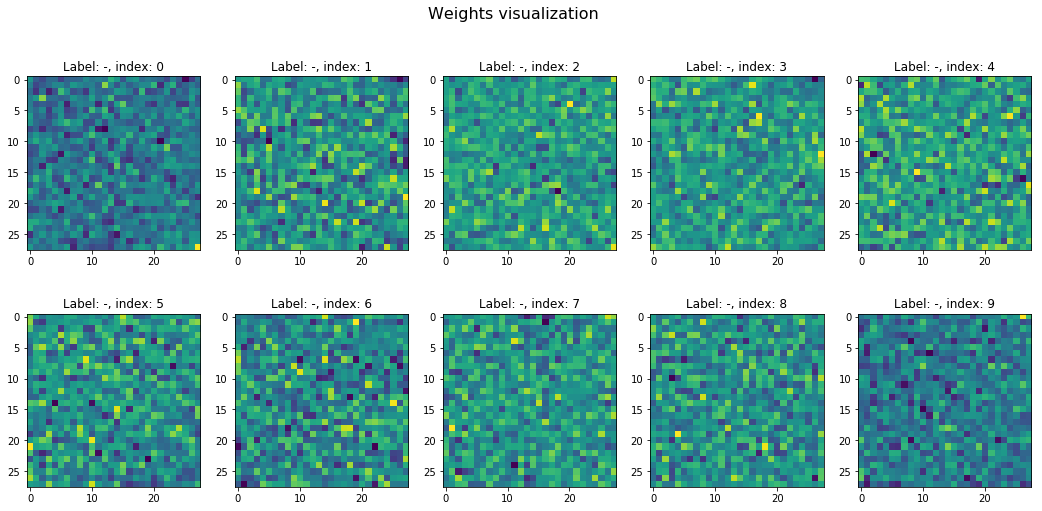

In [112]:
sample_size = 5000

regr.fit(X_train(sample_size), y_train(sample_size))
score = regr.score(X_test, y_test)

print("Score: %s" % (score))
visualize_weights(regr.coef_)